In [1]:
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from os.path import join, isdir, dirname, abspath
from os import listdir
from typing import List
from pathlib import Path
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from collections import OrderedDict
import torch
from scipy.stats import linregress

from matplotlib import colors


root_path = dirname(abspath("./"))
import sys
sys.path.append(root_path)

from prochain_transformer.subroutines.eval_sweeps import get_df_recursive, has_logs_subfolder, get_df_kfold_loss

In [2]:
def post_process_sweep(
    df: pd.DataFrame,
    compound_cols: List[dict],
    columns_name_map: dict=None,
    columns_to_dump: list=None
    ):
    
    df_ = df.copy()
    
    # extract sweeps and base info
    for compound_col in compound_cols:
        df_[compound_col["new_label"]] = df_[compound_col["old_label"]].str.extract(compound_col["regex"])
        df_[compound_col["new_label"]] = df_[compound_col["new_label"]].astype(compound_col["type"])
        
    if columns_name_map is not None:
        df_ = df_.rename(columns=columns_name_map)
        
    if columns_to_dump is not None:
        df_ = df_.drop(columns=columns_to_dump)
        
    return df_

In [9]:
dirpath_sum = "../experiments/training/ishigami_sum/combinations_new"
dirpath_cat = "../experiments/training/ishigami_cat/combinations_new"
df_sum = get_df_recursive(filepath=dirpath_sum, bottom_action=get_df_kfold_loss, is_bottom= has_logs_subfolder)
df_cat = get_df_recursive(filepath=dirpath_cat, bottom_action=get_df_kfold_loss, is_bottom= has_logs_subfolder)
df_cat

k  val_loss  train_loss  test_loss  \
0   k_0  0.240819    0.004036   0.196127   
1   k_1  0.167649    0.006926   0.188848   
2   k_2  0.262696    0.001625   0.300941   
3   k_3  0.532546    0.003532   0.227385   
4   k_4  0.633672    0.006948   0.395171   
..  ...       ...         ...        ...   
0   k_0  0.206081    0.001979   0.171004   
1   k_1  0.278059    0.002049   0.336767   
2   k_2  0.534824    0.002571   0.329427   
3   k_3  0.252945    0.001424   0.428101   
4   k_4  0.357967    0.001862   0.234237   

                                   level_0  
0   combo_d_base_emb_100_max_data_size_100  
1   combo_d_base_emb_100_max_data_size_100  
2   combo_d_base_emb_100_max_data_size_100  
3   combo_d_base_emb_100_max_data_size_100  
4   combo_d_base_emb_100_max_data_size_100  
..                                     ...  
0    combo_d_base_emb_90_max_data_size_200  
1    combo_d_base_emb_90_max_data_size_200  
2    combo_d_base_emb_90_max_data_size_200  
3    combo_d_base_emb_90_max_data_size_200  
4    combo_d_base_emb_90_max_data_size_200  

[217 rows x 5 columns]

In [10]:
columns_name_map = {
    "val_loss"  : "validation",
    "train_loss"  : "train",
    "test_loss"  : "test",
    "level_2": "sweep variable"
    }

compound_cols = [
        {
            "old_label" :"level_0",
            "new_label": ["d_emb", "ds size"],
            "regex":r"(\d+).+?(\d+)", 
            "type":int}
        ]

columns_to_dump = [
    "level_0",
]

df_S = post_process_sweep(df_sum, compound_cols, columns_name_map, columns_to_dump)
df_C = post_process_sweep(df_cat, compound_cols, columns_name_map, columns_to_dump)
df_C

k  validation     train      test  d_emb  ds size
0   k_0    0.240819  0.004036  0.196127    100      100
1   k_1    0.167649  0.006926  0.188848    100      100
2   k_2    0.262696  0.001625  0.300941    100      100
3   k_3    0.532546  0.003532  0.227385    100      100
4   k_4    0.633672  0.006948  0.395171    100      100
..  ...         ...       ...       ...    ...      ...
0   k_0    0.206081  0.001979  0.171004     90      200
1   k_1    0.278059  0.002049  0.336767     90      200
2   k_2    0.534824  0.002571  0.329427     90      200
3   k_3    0.252945  0.001424  0.428101     90      200
4   k_4    0.357967  0.001862  0.234237     90      200

[217 rows x 6 columns]

<Axes: xlabel='d_emb', ylabel='train'>

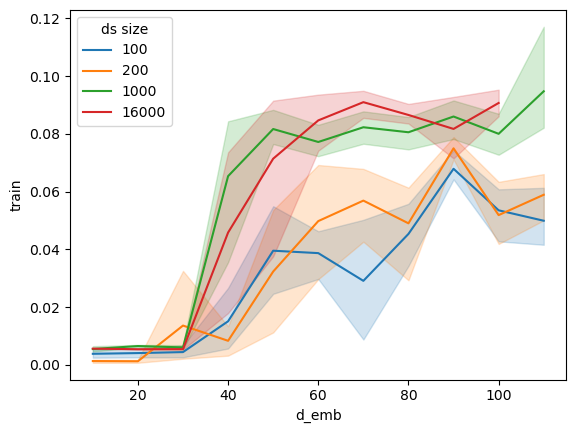

In [11]:
sns.lineplot(df_S, x="d_emb",y="train", hue="ds size", palette="tab10")

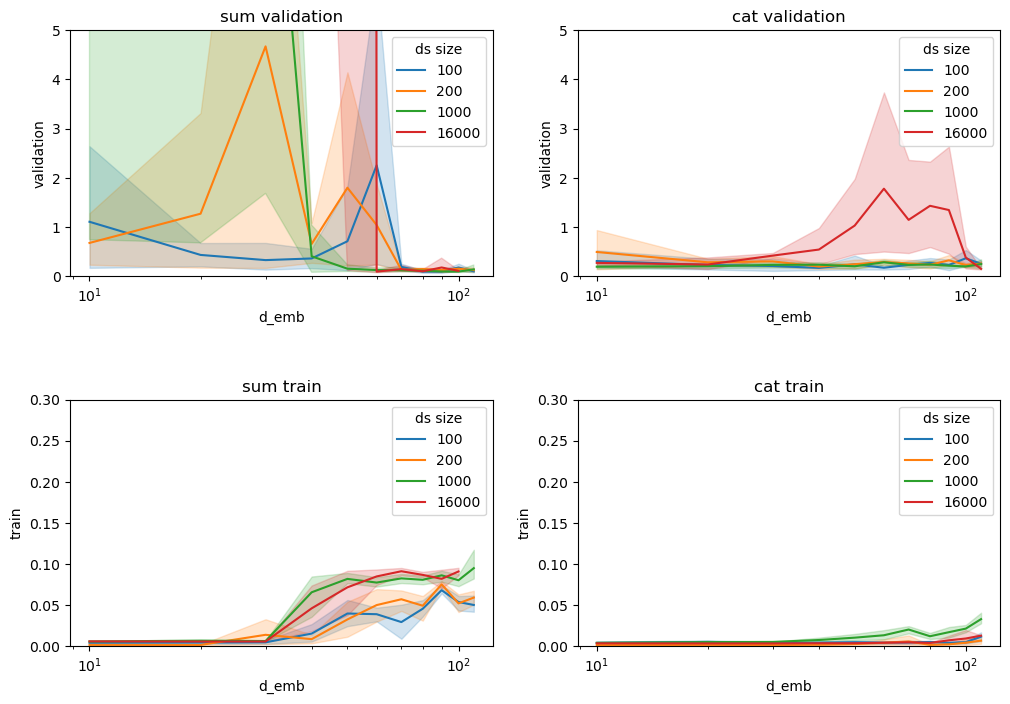

In [12]:
val_lim = (0,5)
train_lim = (0,0.3)
fig = plt.figure(figsize=(12,8))
g = GridSpec(2,2,
             hspace=0.5)
ax0 = fig.add_subplot(g[0,0])
sns.lineplot(df_S, x="d_emb",y="validation", hue="ds size", ax=ax0, palette="tab10")
ax0.set_ylim(val_lim)
ax0.set_title("sum validation")
ax1 = fig.add_subplot(g[1,0])
sns.lineplot(df_S, x="d_emb",y="train", hue="ds size", palette="tab10", ax=ax1)
ax1.set_ylim(train_lim)
ax1.set_title("sum train")
ax2 = fig.add_subplot(g[0,1])
sns.lineplot(df_C, x="d_emb",y="validation", hue="ds size", ax=ax2, palette="tab10")
ax2.set_ylim(val_lim)
ax2.set_title("cat validation")
ax3 = fig.add_subplot(g[1,1])
sns.lineplot(df_C, x="d_emb",y="train", hue="ds size", palette="tab10", ax=ax3)
ax3.set_title("cat train")
ax3.set_ylim(train_lim)

ax0.set_xscale("log")
ax1.set_xscale("log")
ax2.set_xscale("log")
ax3.set_xscale("log")


